In [1]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from my_utils import *

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# dummy trainloader 
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True) 
device = torch.device('cpu')

import matplotlib.pyplot as plt

In this homework, we build a neural network for performing binary classification. We will base our implementation on neural ordinary differential equations (NODEs). We will again use the concentric annuli dataset. 

Let's begin by importing some libaries. 

Next, we set a random seed for reproducibility.

In [2]:
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

# Concentric annuli



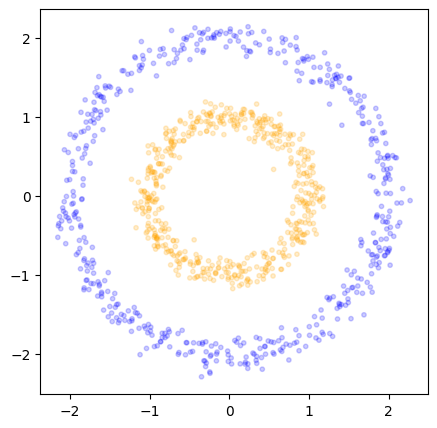

In [3]:
Xtrain, ytrain = sample_annuli()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, Xtrain, ytrain)

First, lets see how a simple shallow neural network would perform. 

In [4]:
class Model(nn.Module):
    def __init__(self,device="cpu"):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,50),
            nn.Tanh(),
            nn.Linear(50,1))
        #for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, x):
        y = self.net(x)
        y = torch.sigmoid(y)
        return y

In [5]:
model = Model().to(device)

In [6]:
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [7]:
for itr in range(1, 501):
    optimizer.zero_grad()
#    x0, y = sample_annuli(device=device, n_samples=1024)
        
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh.squeeze(), ytrain.float())
    print(itr,loss.item())
    #loss_traj[itr-1] = loss.item()
    loss.backward()
    optimizer.step()

1 0.6939455270767212
2 0.6776142120361328
3 0.65314781665802
4 0.6346390843391418
5 0.6130549907684326
6 0.5859909057617188
7 0.5587671399116516
8 0.5281894207000732
9 0.49319690465927124
10 0.4578034281730652
11 0.4197216331958771
12 0.37944117188453674
13 0.33956611156463623
14 0.29894697666168213
15 0.25949031114578247
16 0.22264736890792847
17 0.1881948709487915
18 0.15711233019828796
19 0.1300029158592224
20 0.10624717175960541
21 0.08601053804159164
22 0.06934861093759537
23 0.05547633022069931
24 0.04418657347559929
25 0.03529290482401848
26 0.02820770815014839
27 0.02253609150648117
28 0.018094876781105995
29 0.014660951681435108
30 0.011973747052252293
31 0.009838355705142021
32 0.008139543235301971
33 0.006797658279538155
34 0.0057405875995755196
35 0.004901810549199581
36 0.004226280841976404
37 0.003673604689538479
38 0.003216668264940381
39 0.0028375862166285515
40 0.0025234115310013294
41 0.002263313625007868
42 0.002047465182840824
43 0.00186700071208179
44 0.00171437510

You can see that the model can easily achieve zero error.

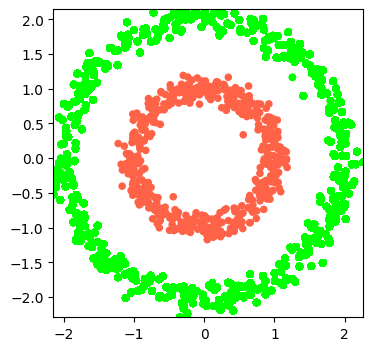

tensor(0)


In [8]:
with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    axes = []
    axes.append(fig.add_subplot(1,1,1))#,sharex=True,sharey=True))
    xs, ys = Xtrain, ytrain#sample_gaussian(n_samples=200) ; s = torch.linspace(0, 1, 10)
    
    y_pred = model(xs)
    
    label = (y_pred[:,0] >= 0.5).long()
    
    colors = ['lime','tomato']
    for i in range(512):
        axes[0].scatter(xs[i,0], xs[i,1], c=colors[label[i]], edgecolor='none', s=30)
        axes[0].scatter(xs[i+512:,0], xs[i+512:,1], c=colors[label[i+512]], edgecolor='none', s=30)
    axes[0].set_xlim(xs[:,0].min(), xs[:,0].max()) ; axes[0].set_ylim(xs[:,1].min(), xs[:,1].max())
    plt.show()
    err = torch.sum(torch.abs(label) - torch.abs(ytrain))
    print(err)
    


# NODEs

Now, lets implement neural ODEs for the binary classification.

First, you need to install a proper API, torchdiffeq (https://github.com/rtqichen/torchdiffeq)

In [9]:
from torchdiffeq import odeint

In the following (the ODEFunc class), we define the right-hand side of the neural ODEs ($f$ in the equation below).

$$ \frac{d x}{d t} = f(x;\theta) $$

In [10]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Tanh(),
            nn.Linear(hdim, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

    def forward(self, t, y):
        return self.net(y)

The model below solves the initial value problem associated with the NODE defined above starting at $t=0$ to the terminal time $t=1$.

In [11]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return torch.sigmoid(yhat)


In [12]:
def dec_bound(model, x):
    P = [p for p in model.linear_layer.parameters()]
    w1, w2, b = P[0][0][0].cpu().detach(), P[0][0][1].cpu().detach(), P[1][0].cpu().detach().item()
    return (-w1*x - b + .5)/w2

1 0.6931472420692444
2 0.6930838823318481
3 0.6930156946182251
4 0.6929415464401245
5 0.6928609013557434
6 0.6927733421325684
7 0.6926784515380859
8 0.6925758123397827
9 0.6924648880958557
10 0.6923452019691467
11 0.6922160387039185
12 0.6920764446258545
13 0.6919259428977966
14 0.6917632818222046
15 0.6915879249572754
16 0.6913984417915344
17 0.6911941170692444
18 0.690973699092865
19 0.6907362937927246
20 0.6904802918434143
21 0.6902046799659729
22 0.6899080872535706
23 0.6895890831947327
24 0.6892460584640503
25 0.6888774037361145
26 0.6884815096855164
27 0.688056468963623
28 0.687600314617157
29 0.6871110796928406
30 0.6865864992141724
31 0.6860243082046509
32 0.6854220628738403
33 0.6847771406173706
34 0.684087336063385
35 0.6833497285842896
36 0.6825621724128723
37 0.6817222237586975
38 0.6808276176452637
39 0.6798765659332275
40 0.6788672208786011
41 0.6777979731559753
42 0.6766676902770996
43 0.6754754185676575
44 0.6742209196090698
45 0.672903835773468
46 0.6715248227119446
47

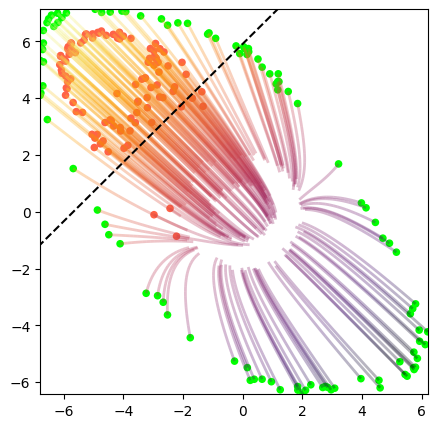

101 0.576991617679596
102 0.5754978656768799
103 0.5740126967430115
104 0.5725376605987549
105 0.5710738301277161
106 0.569621205329895
107 0.5681794881820679
108 0.5667476058006287
109 0.5653244256973267
110 0.5639088153839111
111 0.5624999403953552
112 0.561096727848053
113 0.5596985816955566
114 0.5583049654960632
115 0.5569148063659668
116 0.5555270314216614
117 0.5541403889656067
118 0.5527534484863281
119 0.5513647198677063
120 0.5499728918075562
121 0.5485768914222717
122 0.5471758246421814
123 0.5457690358161926
124 0.5443564057350159
125 0.542937695980072
126 0.5415131449699402
127 0.5400827527046204
128 0.5386469960212708
129 0.5372061133384705
130 0.5357605218887329
131 0.5343104004859924
132 0.5328564643859863
133 0.5313988327980042
134 0.5299379825592041
135 0.5284740924835205
136 0.527006983757019
137 0.5255366563796997
138 0.5240626335144043
139 0.5225841403007507
140 0.5211005210876465
141 0.519611120223999
142 0.5181151628494263
143 0.5166122913360596
144 0.51510196924

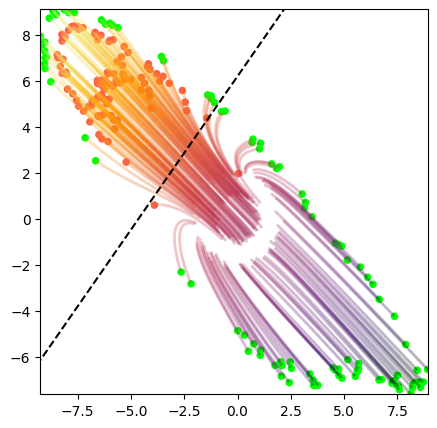

201 0.4078579843044281
202 0.4056794047355652
203 0.4035155177116394
204 0.4013667702674866
205 0.39923378825187683
206 0.397116482257843
207 0.3950141966342926
208 0.39292553067207336
209 0.3908485770225525
210 0.3887817859649658
211 0.38672348856925964
212 0.38467228412628174
213 0.3826269209384918
214 0.3805869221687317
215 0.3785519003868103
216 0.3765210211277008
217 0.37449297308921814
218 0.37246641516685486
219 0.37044113874435425
220 0.3684169352054596
221 0.3663921654224396
222 0.36436429619789124
223 0.36232995986938477
224 0.3602863848209381
225 0.35822969675064087
226 0.35615354776382446
227 0.35405096411705017
228 0.35191988945007324
229 0.34976911544799805
230 0.34760957956314087
231 0.3454369902610779
232 0.3432445228099823
233 0.3410351872444153
234 0.33881327509880066
235 0.336574912071228
236 0.3343118131160736
237 0.33201974630355835
238 0.3297003507614136
239 0.3273565173149109
240 0.324989378452301
241 0.32259905338287354
242 0.32018306851387024
243 0.317739218473

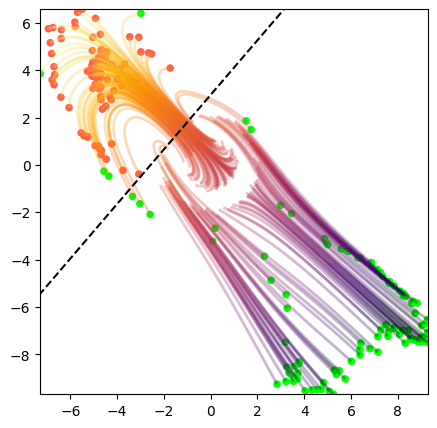

301 0.1609542816877365
302 0.15915609896183014
303 0.15738248825073242
304 0.15562784671783447
305 0.1538911759853363
306 0.15216442942619324
307 0.15044915676116943
308 0.1487351655960083
309 0.14702893793582916
310 0.14533019065856934
311 0.1436517834663391
312 0.1419926881790161
313 0.14034831523895264
314 0.1387191116809845
315 0.13711139559745789
316 0.13553135097026825
317 0.13402003049850464
318 0.13267835974693298
319 0.13208872079849243
320 0.12947393953800201
321 0.12884683907032013
322 0.1286916881799698
323 0.1263275444507599
324 0.12532226741313934
325 0.12289969623088837
326 0.1222778856754303
327 0.12080621719360352
328 0.11941435933113098
329 0.118403360247612
330 0.11708112806081772
331 0.11620521545410156
332 0.11468161642551422
333 0.11414561420679092
334 0.11262945085763931
335 0.11197490245103836
336 0.11052410304546356
337 0.1099611148238182
338 0.10854421555995941
339 0.10786250233650208
340 0.1067047268152237
341 0.1059296578168869
342 0.10485538095235825
343 0.

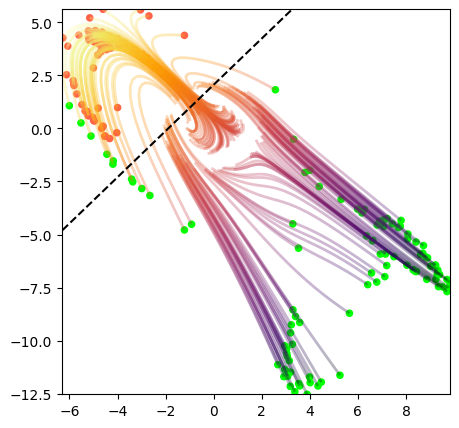

401 0.06955286860466003
402 0.06917377561330795
403 0.06878414750099182
404 0.06839432567358017
405 0.06802107393741608
406 0.0676584243774414
407 0.06728348881006241
408 0.06691968441009521
409 0.06656898558139801
410 0.0662165954709053
411 0.06586115062236786
412 0.0655319094657898
413 0.06517813354730606
414 0.0648423433303833
415 0.06451210379600525
416 0.06417931616306305
417 0.06385190784931183
418 0.06352966278791428
419 0.06320897489786148
420 0.0628926008939743
421 0.06257457286119461
422 0.06227076053619385
423 0.061979055404663086
424 0.06164884567260742
425 0.06137239187955856
426 0.06106828898191452
427 0.06074647605419159
428 0.060466501861810684
429 0.06018311157822609
430 0.05986607447266579
431 0.059617411345243454
432 0.05931629613041878
433 0.059023432433605194
434 0.05877762660384178
435 0.05845083296298981
436 0.05817675590515137
437 0.05791551619768143
438 0.05765161290764809
439 0.05737178027629852
440 0.05709933489561081
441 0.05682617798447609
442 0.05656267702

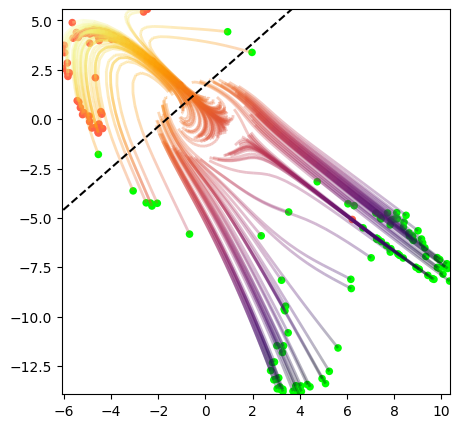

In [13]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh[-1], ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)
#            ax.scatter(xS[-1,:,-2], xS[-1,:,-1], c='lime', edgecolor='none', s=30)
#            ax.scatter(xS[0,:,-2], xS[0,:,-1], c='black', alpha=.5, s=30)
            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [14]:
label = (yh[1,:,0] >= 0.5).long()

In [15]:
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.0146)


<b>[Questions]</b>

You can see that the neural ODEs fail to achieve 100% accuracy. This is somewhat odd considering that the simple shallow network could achieve 100% accuracy and NODEs are an advanced version of ResNets. 

[2 pts] Can you explain why NODEs (by design) fail and are not suitable for performing this task? 

[2 pts] now implement variants of NODEs that overcome the issue of NODEs shown above. Any variant of NODE will be accepted. The resulting model should achieve 100% accuracy. Following is the one such variant. See the implementation below (Not all parts of the implementation is revealed; I removed one important block myDepthCat.) 

In [16]:
import torch.nn.functional as F

class myDepthCat(nn.Module):
    def __init__(self, app_dim):
        super(myDepthCat, self).__init__()
        self.app_dim = app_dim
        self.t = 0

    def forward(self, x):
        t_val = self.t.item() if isinstance(self.t, torch.Tensor) else self.t 
        t_tnsr = torch.full((x.size(0), self.app_dim), t_val, device=x.device) 
        return torch.cat([x, t_tnsr], dim=1)
    

In [17]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            myDepthCat(1),
            nn.Linear(2+1, hdim),
            nn.Tanh(),
            myDepthCat(1),
            nn.Linear(hdim+1, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

        #for p in self.net[-1].parameters(): torch.nn.init.zeros_(p)

    def forward(self, t, y):
        for _, module in self.net.named_modules():
            if hasattr(module, 't'):
                module.t = t
        return self.net(y)

In [18]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return yhat


1 0.6931472420692444
2 0.6930944323539734
3 0.6930364370346069
4 0.69297194480896
5 0.692900538444519
6 0.692821741104126
7 0.6927350163459778
8 0.6926400661468506
9 0.6925363540649414
10 0.6924233436584473
11 0.6923004388809204
12 0.6921671032905579
13 0.6920228600502014
14 0.6918669939041138
15 0.6916986107826233
16 0.6915172934532166
17 0.691321849822998
18 0.6911118030548096
19 0.6908859014511108
20 0.690643310546875
21 0.690382719039917
22 0.690102756023407
23 0.6898018717765808
24 0.6894784569740295
25 0.6891301870346069
26 0.688755214214325
27 0.6883511543273926
28 0.6879156827926636
29 0.6874462366104126
30 0.6869404315948486
31 0.6863955855369568
32 0.6858091354370117
33 0.6851786375045776
34 0.6845014691352844
35 0.6837751865386963
36 0.6829977631568909
37 0.6821667551994324
38 0.681280791759491
39 0.6803381443023682
40 0.679337739944458
41 0.6782790422439575
42 0.677161455154419
43 0.6759851574897766
44 0.6747506260871887
45 0.6734586954116821
46 0.6721106171607971
47 0.6707

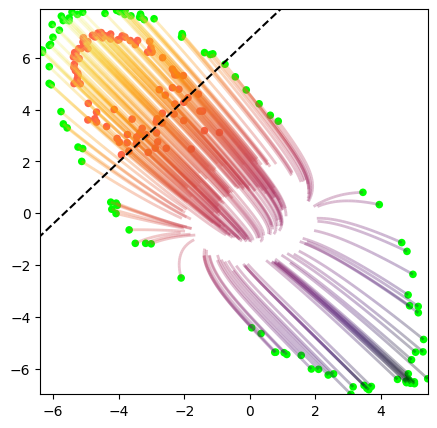

101 0.5853246450424194
102 0.5836873650550842
103 0.5820590853691101
104 0.5804361701011658
105 0.5788142681121826
106 0.5771905779838562
107 0.5755648016929626
108 0.5739381909370422
109 0.5723124146461487
110 0.5706889033317566
111 0.5690678954124451
112 0.5674492716789246
113 0.5658323168754578
114 0.5642163753509521
115 0.56260085105896
116 0.5609851479530334
117 0.5593690276145935
118 0.5577515959739685
119 0.5561318397521973
120 0.554507851600647
121 0.5528779029846191
122 0.5512399077415466
123 0.5495926737785339
124 0.5479360222816467
125 0.5462712049484253
126 0.5445995926856995
127 0.5429224967956543
128 0.5412408113479614
129 0.5395550727844238
130 0.5378663539886475
131 0.5361758470535278
132 0.5344847440719604
133 0.5327942967414856
134 0.5311048030853271
135 0.5294157266616821
136 0.5277253985404968
137 0.5260317921638489
138 0.5243321657180786
139 0.522623598575592
140 0.520903468132019
141 0.5191705226898193
142 0.5174253582954407
143 0.5156689882278442
144 0.5139023065

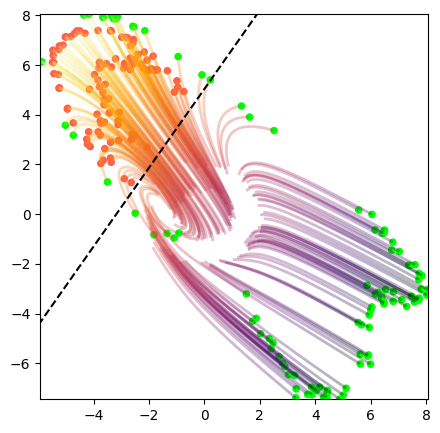

201 0.35590553283691406
202 0.35247936844825745
203 0.3490641415119171
204 0.3456609845161438
205 0.34227195382118225
206 0.33889979124069214
207 0.3355470597743988
208 0.33221593499183655
209 0.32890790700912476
210 0.3256242275238037
211 0.32236579060554504
212 0.31913378834724426
213 0.3159295916557312
214 0.3127552270889282
215 0.30961257219314575
216 0.30650341510772705
217 0.30342963337898254
218 0.30039286613464355
219 0.29739445447921753
220 0.2944350242614746
221 0.2915157377719879
222 0.28863751888275146
223 0.28580164909362793
224 0.2830091714859009
225 0.2802606225013733
226 0.2775562107563019
227 0.27489566802978516
228 0.27227821946144104
229 0.26970261335372925
230 0.26716750860214233
231 0.2646712362766266
232 0.2622124254703522
233 0.25978946685791016
234 0.257400780916214
235 0.255044549703598
236 0.2527190148830414
237 0.2504224479198456
238 0.2481529861688614
239 0.2459089457988739
240 0.24368883669376373
241 0.24149110913276672
242 0.2393142282962799
243 0.23715661

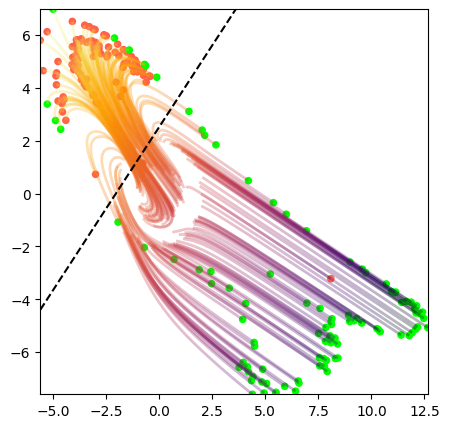

301 0.1191122829914093
302 0.11708037555217743
303 0.11506476998329163
304 0.11306653916835785
305 0.11108671873807907
306 0.10912628471851349
307 0.10718604922294617
308 0.10526665300130844
309 0.10336869955062866
310 0.10149285197257996
311 0.09963962435722351
312 0.09780941903591156
313 0.09600257128477097
314 0.09421922266483307
315 0.09245957434177399
316 0.09072365611791611
317 0.08901143819093704
318 0.08732274174690247
319 0.08565744757652283
320 0.084015391767025
321 0.08239641785621643
322 0.08080019801855087
323 0.0792265236377716
324 0.07767507433891296
325 0.07614561915397644
326 0.07463786005973816
327 0.07315150648355484
328 0.07168632745742798
329 0.07024210691452026
330 0.06881863623857498
331 0.0674157440662384
332 0.0660332515835762
333 0.06467095017433167
334 0.06332877278327942
335 0.06200651824474335
336 0.0607040710747242
337 0.05942133441567421
338 0.05815819650888443
339 0.056914590299129486
340 0.05569040775299072
341 0.054485566914081573
342 0.053300015628337

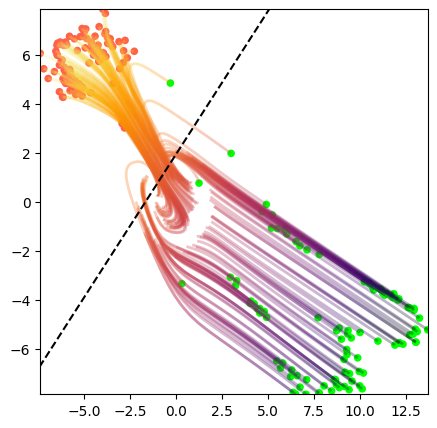

401 0.014807002618908882
402 0.014543246477842331
403 0.014286362566053867
404 0.014036108739674091
405 0.013792317360639572
406 0.013554751873016357
407 0.013323233462870121
408 0.013097564689815044
409 0.0128775704652071
410 0.012663066387176514
411 0.012453886680305004
412 0.01224987581372261
413 0.012050864286720753
414 0.011856713332235813
415 0.011667272076010704
416 0.011482389643788338
417 0.011301930993795395
418 0.011125771328806877
419 0.010953772813081741
420 0.010785832069814205
421 0.010621813125908375
422 0.010461589321494102
423 0.010305077768862247
424 0.010152153670787811
425 0.010002726688981056
426 0.00985666923224926
427 0.009713915176689625
428 0.009574351832270622
429 0.009437895379960537
430 0.009304452687501907
431 0.009173939935863018
432 0.009046271443367004
433 0.008921380154788494
434 0.008799177594482899
435 0.008679588325321674
436 0.008562544360756874
437 0.008447973057627678
438 0.008335809223353863
439 0.008225980214774609
440 0.008118431083858013
441 

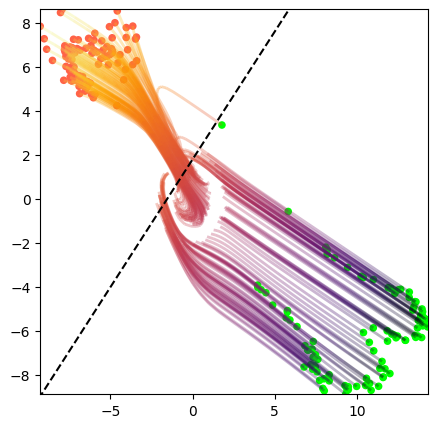

In [19]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(torch.sigmoid(yh[-1]), ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)

            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [22]:
model.eval()
with torch.no_grad():
    y_hat = model(Xtrain)
    pred_labels = (torch.sigmoid(y_hat[-1]) >= 0.5).float()
    c_pred = (pred_labels == ytrain[:, None]).float().sum()
    accuracy = (c_pred / ytrain.shape[0]) * 100
    print("Final accuracy is: " + str(round(accuracy.item(), 2)) + "%")

Final accuracy is: 100.0%


In [ ]:
label = (yh[1,:,0] >= 0.5).long()
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)